*Note: the Poisson distribution is discrete while the others are continuous. We use the Poisson distribution to model arrivals (users coming to login for this example). Discrete distributions have PMFs (probability mass functions) instead of PDFs.*

In [ ]:
!pip install numpy pandas matplotlib

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

log = pd.read_csv('logs/log.csv', index_col='datetime', parse_dates=True)
attacks = pd.read_csv(
    'logs/attack.csv',
    converters={'start': np.datetime64, 'end': np.datetime64}
) # make start and end columns datetimes but not the index

## Understanding the Data
The login attempts recorded from the website look like this:

In [47]:
log.head()

,source_ip,username,success,failure_reason
datetime,,,,
2022-01-01 00:00:01,44.92.75.114,ZackWallace,True,NaN
2022-01-01 00:02:02,44.92.75.114,ZackWallace,True,NaN
2022-01-01 00:12:03,44.92.75.114,ZackWallace,True,NaN
2022-01-01 01:01:01,120.201.57.21,ArmandoWallace,True,NaN
2022-01-01 01:02:02,120.201.57.21,ArmandoWallace,True,NaN


In [48]:
attacks.head()

,start,end,source_ip
0,2022-01-01 14:32:00,2022-01-01 14:32:31,155.82.30.97
1,2022-01-01 16:41:00,2022-01-01 16:47:02,79.82.174.35
2,2022-01-03 03:05:00,2022-01-03 03:09:01,125.164.225.184
3,2022-01-03 07:38:00,2022-01-03 07:39:19,196.213.250.189
4,2022-01-03 13:21:00,2022-01-03 13:22:08,161.149.245.219


In [49]:
attacks.shape, log.shape

((76, 3), (20691, 4))

What percentage of IP addresses were from attackers?

In [50]:
attacks.source_ip.nunique() / log.source_ip.nunique()

0.16033755274261605

## EDA

[Text(0.5, 0, 'datetime'), Text(0, 0.5, 'attempts')]

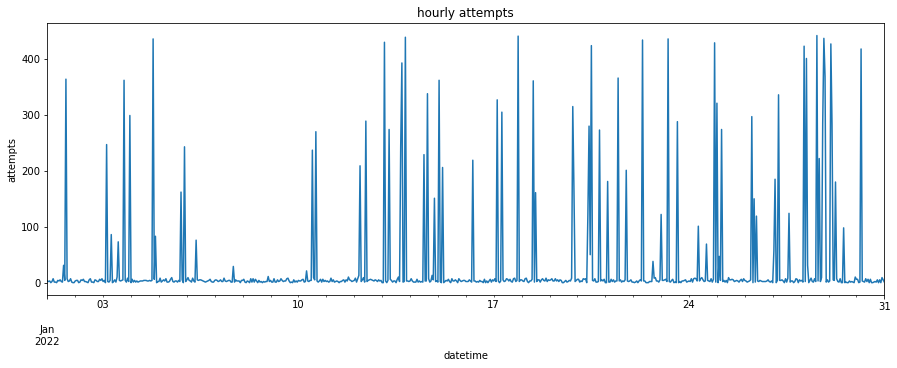

In [51]:
# attempts over time
log.assign(attempts=1).attempts.resample('1H').sum()\
    .plot(figsize=(15, 5), title='hourly attempts')\
    .set(xlabel='datetime', ylabel='attempts')

How many attempts came from each IP address?

In [52]:
log.source_ip.value_counts().describe()

count    474.000000
mean      43.651899
std      102.298774
min        1.000000
25%        3.000000
50%        6.000000
75%       11.000000
max      437.000000
Name: source_ip, dtype: float64

What does the distribution of attempts per IP address look like?

Text(0.5, 0.98, 'Attempts per IP Address')

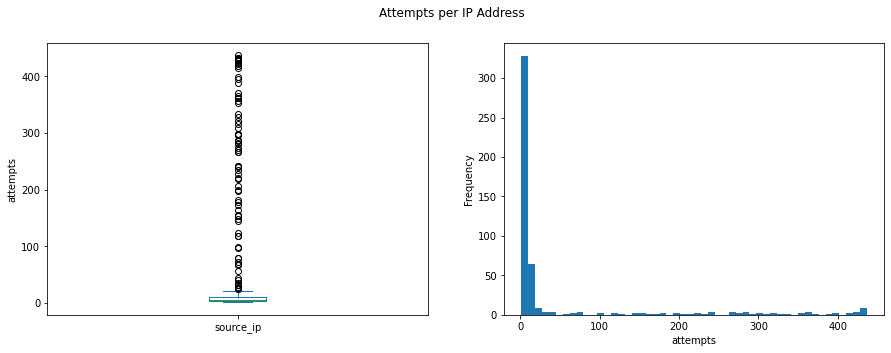

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
log.source_ip.value_counts().plot(kind='box', ax=axes[0]).set_ylabel('attempts')
log.source_ip.value_counts().plot(kind='hist', bins=50, ax=axes[1]).set_xlabel('attempts')
fig.suptitle('Attempts per IP Address')

What percent of the top IP addresses are hackers?

In [54]:
num_hackers = attacks.source_ip.nunique()
log.source_ip.value_counts().index[:num_hackers]\
    .isin(attacks.source_ip).sum() / num_hackers

0.9605263157894737

What does the average hourly attempts per IP address look like over the time period?

Text(0, 0.5, 'average hourly attempts per IP address')

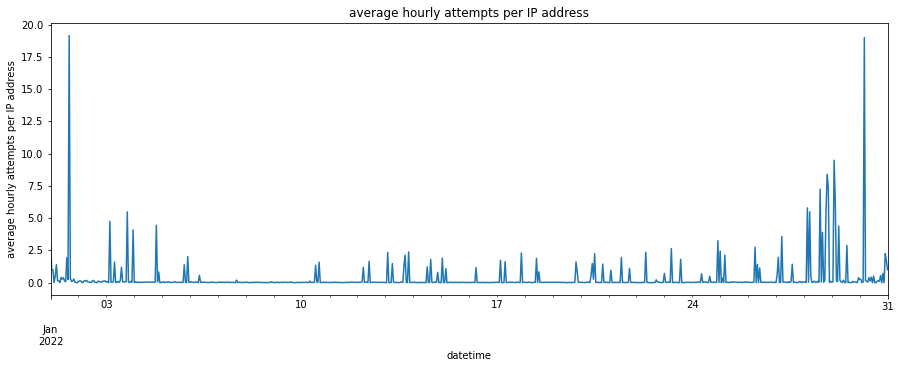

In [55]:
# attempts per ip address
log.assign(attempts=1).groupby('source_ip').attempts\
    .resample('1H').sum().unstack().mean()\
    .plot(figsize=(15, 5), title='average hourly attempts per IP address')\
    .set_ylabel('average hourly attempts per IP address')

What percentage of the time was a hacker's attempt successful?

In [56]:
log[log.source_ip.isin(attacks.source_ip)]\
    .success.value_counts(normalize=True)

False    0.846083
True     0.153917
Name: success, dtype: float64

What percentage of the time are valid users' attempts successful?

In [57]:
log[~log.source_ip.isin(attacks.source_ip)]\
    .success.value_counts(normalize=True)

True     0.870482
False    0.129518
Name: success, dtype: float64

Why is each group failing?

In [58]:
pd.crosstab(
    index=pd.Series(
        log.source_ip.isin(attacks.source_ip), name='is_hacker'
    ), columns=log.failure_reason
)

failure_reason,ErrorWrongPassword,ErrorWrongUsername
is_hacker,,
False,294,7
True,5134,10406


How many times does a user try to log in per hour? Valid users don't make many mistakes with their credentials, so if the hackers make many attempts with many users, we flag it.

Text(0, 0.5, 'average hourly attempts per user')

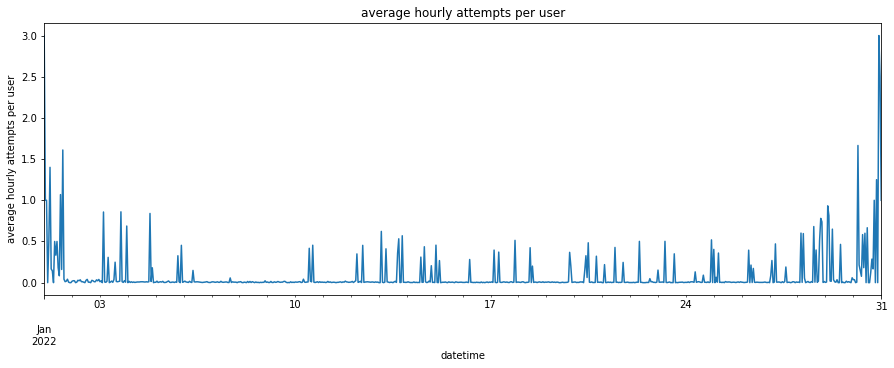

In [59]:
# attempts per user
log.assign(attempts=1).groupby('username').attempts\
    .resample('1H').sum().unstack().mean()\
    .plot(figsize=(15, 5), title='average hourly attempts per user')\
    .set_ylabel('average hourly attempts per user')

Calculate metrics per IP address

In [60]:
pivot = log.pivot_table(
    values='success', index=log.source_ip, 
    columns=log.failure_reason.fillna('success'), 
    aggfunc='count', fill_value=0
)
pivot.insert(0, 'attempts', pivot.sum(axis=1))
pivot = pivot.sort_values('attempts', ascending=False).assign(
    success_rate=lambda x: x.success / x.attempts,
    error_rate=lambda x: 1 - x.success_rate
)
pivot.head()

failure_reason,attempts,ErrorWrongPassword,ErrorWrongUsername,success,success_rate,error_rate
source_ip,,,,,,
70.167.186.223,437,119,259,59,0.135011,0.864989
19.252.122.65,433,134,228,71,0.163972,0.836028
194.195.154.137,432,111,256,65,0.150463,0.849537
122.163.243.73,431,119,247,65,0.150812,0.849188
136.73.0.233,430,119,253,58,0.134884,0.865116


Most successful IP addresses:

In [61]:
pivot.sort_values('success_rate', ascending=False).head()

failure_reason,attempts,ErrorWrongPassword,ErrorWrongUsername,success,success_rate,error_rate
source_ip,,,,,,
16.236.44.240,1,0,0,1,1.0,0.0
223.34.195.68,3,0,0,3,1.0,0.0
81.174.175.226,3,0,0,3,1.0,0.0
134.88.46.31,3,0,0,3,1.0,0.0
77.237.238.180,3,0,0,3,1.0,0.0


What looks out of place with the five-number summary?

In [62]:
pivot.describe()

failure_reason,attempts,ErrorWrongPassword,ErrorWrongUsername,success,success_rate,error_rate
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,43.651899,11.451477,21.968354,10.232068,0.775437,0.224563
std,102.298774,28.993306,59.104031,14.984874,0.296231,0.296231
min,1.000000,0.000000,0.000000,1.000000,0.037037,0.000000
25%,3.000000,0.000000,0.000000,3.000000,0.714286,0.000000
50%,6.000000,1.000000,0.000000,5.000000,0.875000,0.125000
75%,11.000000,2.000000,0.000000,9.000000,1.000000,0.285714
max,437.000000,140.000000,259.000000,77.000000,1.000000,0.962963


Are there IP addresses being used with many distinct usernames?

In [63]:
log.groupby('source_ip').agg(dict(username='nunique'))\
    .username.value_counts().describe()

count     64.000000
mean       7.406250
std       48.717755
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      391.000000
Name: username, dtype: float64

### Visual Anomaly Detection
We had a bimodal distribution of attempts per IP address &mdash; will we have two clusters when we plot successes vs. attempts by IP address?

<AxesSubplot:title={'center':'successes vs. attempts by IP address'}, xlabel='attempts', ylabel='success'>

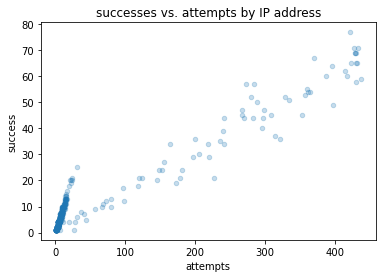

In [64]:
pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP address', alpha=0.25
)

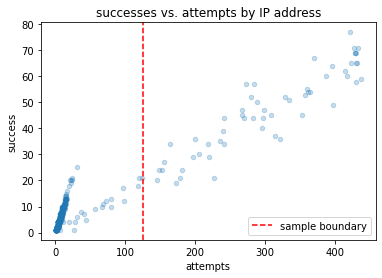

In [65]:
ax = pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP address', alpha=0.25
)
plt.axvline(125, label='sample boundary', color='red', linestyle='--')
plt.legend(loc='lower right')

Text(0.5, 0.98, 'successes vs. attempts by IP address')

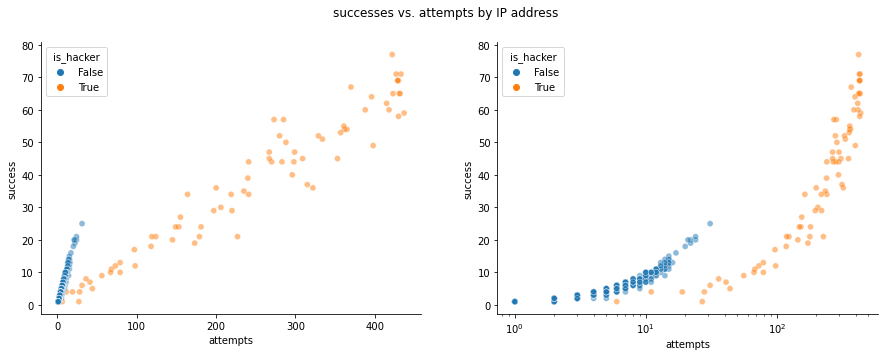

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax in axes:
    sns.scatterplot(
        y=pivot.success, x=pivot.attempts, 
        hue=pivot.assign(
            is_hacker=lambda x: x.index.isin(attacks.source_ip)
        ).is_hacker,
        ax=ax, alpha=0.5
    )
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
axes[1].set_xscale('log')
plt.suptitle('successes vs. attempts by IP address')

Can a box plot show us outliers corresponding to the top right cluster in the previous scatter plots?

attempts       AxesSubplot(0.125,0.125;0.352273x0.755)
success     AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

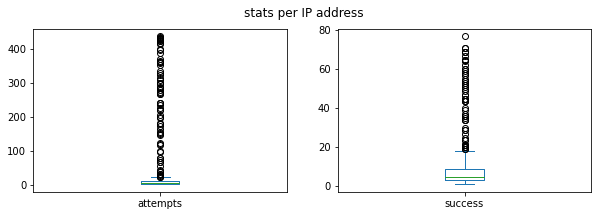

In [67]:
pivot[['attempts', 'success']].plot(
    kind='box', subplots=True, figsize=(10, 3),
    title='stats per IP address'
)

## Rule-based Anomaly Detection
We want to find the IP addresses with excessive amounts of attempts with low success rates and those attempting to log in with more unique usernames than we would deem normal (anomalies).

In [68]:
hourly_ip_logs = log.assign(
    failures=lambda x: np.invert(x.success)
).groupby('source_ip').resample('1H').agg(
    {'username': 'nunique', 'success': 'sum', 'failures': 'sum'}
).assign(
    attempts=lambda x: x.success + x.failures,
    success_rate=lambda x: x.success / x.attempts,
    failure_rate=lambda x: 1 - x.success_rate
).dropna().reset_index()

The data we will use for rule-based anomaly detection looks like this:

In [69]:
hourly_ip_logs.head()

,source_ip,datetime,username,success,failures,attempts,success_rate,failure_rate
0,0.122.45.19,2022-01-18 02:00:00,1,1,0,1,1.000000,0.000000
1,0.122.45.19,2022-01-20 10:00:00,1,1,0,1,1.000000,0.000000
2,0.182.78.111,2022-01-08 12:00:00,1,3,0,3,1.000000,0.000000
3,0.182.78.111,2022-01-08 21:00:00,1,2,0,2,1.000000,0.000000
4,0.182.78.111,2022-01-13 05:00:00,1,2,1,3,0.666667,0.333333


### Percent Difference from Threshold
A simple rule would be to check if values are a certain percentage or more different from some threshold. 

#### Bootstrapping
In our case, the threshold will be an hourly baseline of login activity. We could use bootstrapping to calculate the baseline with random sample of size 10 for each hour:

In [70]:
def get_baselines(hourly_ip_logs, func, *args, **kwargs):
    """
    Calculate hourly bootstrapped statistic per column.
    
    Parameters:
        - hourly_ip_logs: Data to sample from.
        - func: Statistic to calculate.
        - args: Additional positional arguments for `func`
        - kwargs: Additional keyword arguments for `func`
    
    Returns:
        `pandas.DataFrame` of hourly bootstrapped statistics
    """
    if isinstance(func, str):
        func = getattr(pd.DataFrame, func)

    return hourly_ip_logs\
        .assign(hour=lambda x: x.datetime.dt.hour).groupby('hour')\
        .apply(
            lambda x: x.sample(10, random_state=0, replace=True)\
                .pipe(func, *args, **kwargs, numeric_only=True)
        )

In [71]:
averages = get_baselines(hourly_ip_logs, 'mean')
averages.shape

(24, 7)

This technique however doesn't guarantee we won't mix any of the hacker activity into our baseline calculations:

In [72]:
averages.nlargest(6, 'failure_rate')

,username,success,failures,attempts,success_rate,failure_rate,hour
hour,,,,,,,
4,47.7,13.7,70.5,84.2,0.744066,0.255934,4.0
16,16.0,4.3,21.9,26.2,0.750219,0.249781,16.0
1,44.6,12.6,61.8,74.4,0.779834,0.220166,1.0
17,23.4,7.9,33.0,40.9,0.832131,0.167869,17.0
18,1.0,1.8,0.5,2.3,0.833333,0.166667,18.0
14,1.0,2.1,0.6,2.7,0.850000,0.150000,14.0


#### Trimming
We need to remove some of the outliers for better baselines. Let's write a function to trim values beyond a given quantile:

In [73]:
def trim(x, quantile):
    """Remove rows with entries for the username, attempts, or failure_rate columns above a given quantile."""
    mask = ((x.username <= x.username.quantile(quantile))
        & (x.attempts <= x.attempts.quantile(quantile))
        & (x.failure_rate <= x.failure_rate.quantile(quantile)))
    return x[mask]

In [74]:
trimmed_hourly_logs = hourly_ip_logs\
    .assign(hour=lambda x: x.datetime.dt.hour)\
    .groupby('hour').apply(lambda x: trim(x, 0.95))\
    .drop(columns='hour').reset_index().iloc[:,2:]

In [75]:
averages = get_baselines(trimmed_hourly_logs, 'mean')
averages.iloc[[19, 23, 3, 11, 14, 16]]

,username,success,failures,attempts,success_rate,failure_rate,hour
hour,,,,,,,
19,1.0,2.3,0.3,2.6,0.908333,0.091667,19.0
23,1.0,2.0,0.2,2.2,0.941667,0.058333,23.0
3,1.0,2.4,0.3,2.7,0.943333,0.056667,3.0
11,1.0,2.0,0.4,2.4,0.907143,0.092857,11.0
14,1.0,2.3,0.5,2.8,0.900000,0.100000,14.0
16,1.2,1.5,0.3,1.8,0.883333,0.116667,16.0


In [76]:
def pct_change_threshold(hourly_ip_logs, baselines, pcts=None):
    """
    Return flagged IP addresses based on thresholds.
    
    Parameters:
        - hourly_ip_logs: Aggregated hourly data per IP address.
        - baselines: Hourly baselines per column in data.
        - pcts: Dictionary of custom percentages per column for
                calculating upper bound thresholds (baseline * pct).
                If not provided, pct will be 1.
    
    Returns:
        `pandas.Series` containing the IP addresses flagged.
    """
    pcts = {} if not pcts else pcts

    return hourly_ip_logs.assign(
        hour=lambda x: x.datetime.dt.hour
    ).join(
        baselines, on='hour', rsuffix='_baseline'
    ).assign(
        too_many_users=lambda x: x.username_baseline \
            * pcts.get('username', 1) <= x.username,
        too_many_attempts=lambda x: x.attempts_baseline \
            * pcts.get('attempts', 1) <= x.attempts,
        high_failure_rate=lambda x: x.failure_rate_baseline \
            * pcts.get('failure_rate', 1) <= x.failure_rate
    ).query(
        'too_many_users and too_many_attempts and high_failure_rate'
    ).source_ip.drop_duplicates()

Let's see how many IP addresses get flagged for being 25% greater than the mean baselines for distinct usernames, number of attempts, and failure rate:

In [77]:
pct_from_mean_ips = pct_change_threshold(
    hourly_ip_logs, averages, 
    {key: 1.25 for key in ['username', 'attempts', 'failure_rate']}
)
pct_from_mean_ips.nunique()

83

### Tukey Fence
Another strategy is to use the upper bound of the Tukey fence. The multiplier on the IQR is a parameter we will want to tune:

In [78]:
def tukey_fence_test(trimmed_data, logs, k, pct=None):
    """
    See which IP addresses get flagged with a Tukey fence with
    multiplier k and optional percent differences.
    
    Parameters: 
        - trimmed_data: The data to use to calculate the baselines
        - logs: The data to test
        - k: The multiplier for the IQR
        - pct: Dictionary of percentages per column for use with `pct_change_threshold()`
        
    Returns:
        `pandas.Series` of flagged IP addresses
    """
    q3 = get_baselines(trimmed_data, 'quantile', .75).drop(columns=['hour'])
    q1 = get_baselines(trimmed_data, 'quantile', .25).drop(columns=['hour'])
    iqr = q3 - q1
    upper_bound = (q3 + k * iqr).reset_index()
    return pct_change_threshold(logs, upper_bound, pct)

In [79]:
tukey_fence_ips = tukey_fence_test(
    trimmed_hourly_logs, hourly_ip_logs, k=3
)

In [80]:
tukey_fence_ips.nunique()

42

### Z-score

In [81]:
def z_score_test(trimmed_data, logs, cutoff):
    """
    See which IP addresses get flagged with a Z-score greater than
    or equal to a cutoff value.
    
    Parameters: 
        - trimmed_data: The data to use to calculate the baselines
        - logs: The data to test
        - cutoff: Flag row when z_score >= cutoff
        
    Returns:
        `pandas.Series` of flagged IP addresses
    """
    std_dev = get_baselines(trimmed_data, 'std').drop(columns=['hour'])
    averages = get_baselines(trimmed_data, 'mean').drop(columns=['hour'])

    return logs.assign(
        hour=lambda x: x.datetime.dt.hour
    ).join(
        std_dev.join(
            averages, 
            lsuffix='_std', 
            rsuffix='_mean'
        ),
        on='hour'
    ).assign(
        too_many_users=lambda x: \
            (x.username - x.username_mean) / x.username_std >= cutoff,
        too_many_attempts=lambda x: \
            (x.attempts - x.attempts_mean) / x.attempts_std >= cutoff,
        high_failure_rate=lambda x: \
            (x.failure_rate - x.failure_rate_mean) / x.failure_rate_std >= cutoff
    ).query(
        'too_many_users and too_many_attempts and high_failure_rate'
    ).source_ip.drop_duplicates()

z_score_ips = z_score_test(trimmed_hourly_logs, hourly_ip_logs, 3)
z_score_ips.nunique()

67

### Evaluating Methods

In [82]:
def evaluate(alerted_ips, attack_ips, log_ips):
    """
    Calculate true positives (TP), false positives (FP), 
    true negatives (TN), and false negatives (FN) for 
    IP addresses flagged as suspicious.
    
    Parameters:
        - alerted_ips: `pandas.Series` of flagged IP addresses
        - attack_ips: `pandas.Series` of attacker IP addresses
        - log_ips: `pandas.Series` of all IP addresses seen
    
    Returns:
        Tuple of form (TP, FP, TN, FN)
    """
    tp = alerted_ips.isin(attack_ips).sum()
    tn = np.invert(np.isin(log_ips[~log_ips.isin(alerted_ips)].unique(), attack_ips)).sum()
    fp = np.invert(alerted_ips.isin(attack_ips)).sum()
    fn = np.invert(attack_ips.isin(alerted_ips)).sum()
    return tp, fp, tn, fn

Using, partials we can reduce our typing later by providing the arguments only once:

In [83]:
# make this easier to call
from functools import partial
scores = partial(evaluate, attack_ips=attacks.source_ip, log_ips=pivot.index)

#### Percent Difference from Mean
Let's see how well the percent difference from the mean method did. Using our partial, we get all the components of the confusion matrix:

In [84]:
tp, fp, tn, fn = scores(pct_from_mean_ips)

We can use these to calculate the **false positive rate (FPR)** or the false alarm rate:

$$ FPR = \frac{FP}{FP + TN} $$ 

and the **false discovery rate (FDR)** or the percentage of our alarms that are wrong:

$$ FDR = \frac{FP}{FP + TP} $$ 

In [85]:
# fpr, fdr
fp / (fp + tn), fp / (fp + tp)

(0.017587939698492462, 0.08433734939759036)

To look into false negatives, we can calculate the **false negative rate (FNR)** or the miss rate:

$$ FNR = \frac{FN}{FN + TP} $$

and the **false omission rate (FOR)**:

$$ FOR = \frac{FN}{FN + TN} $$

In [86]:
# fnr, for
fn / (fn + tp), fn / (fn + tn)

(0.0, 0.0)

Let's create a function to calculate all of this for us, so we can compare the methods:

In [87]:
def classification_stats(tp, fp, tn, fn):
    """Calculate metrics"""
    return {
        'FPR': fp / (fp + tn),
        'FDR': fp / (fp + tp),
        'FNR': fn / (fn + tp),
        'FOR': fn / (fn + tn)
    }

Percent difference from the mean using trimmed baselines performs well all around:

In [88]:
classification_stats(tp, fp, tn, fn)

{'FPR': 0.017587939698492462,
 'FDR': 0.08433734939759036,
 'FNR': 0.0,
 'FOR': 0.0}

#### Percent Difference from the Median
We don't need to use the trimmed data here because the median is robust to outliers:

In [89]:
medians = get_baselines(hourly_ip_logs, 'median')
pct_from_median_ips = pct_change_threshold(
    hourly_ip_logs, medians, 
    {key: 1.25 for key in ['username', 'attempts', 'failure_rate']}
)
tp, fp, tn, fn = scores(pct_from_median_ips)
classification_stats(tp, fp, tn, fn)

{'FPR': 0.01256281407035176,
 'FDR': 0.06172839506172839,
 'FNR': 0.0,
 'FOR': 0.0}

#### Comparing Methods
We can use a `DataFrame` object to easily compare the methods we tried. All perform well, which one we use in practice will depend on the cost of false negatives vs. false positives:

In [90]:
pd.DataFrame({
    method: classification_stats(*scores(ips))
    for method, ips in {
        'means': pct_from_mean_ips,
        'medians': pct_from_median_ips,
        'Tukey fence': tukey_fence_ips,
        'Z-scores': z_score_ips
    }.items()
})

,means,medians,Tukey fence,Z-scores
FPR,0.017588,0.012563,0.000000,0.000000
FDR,0.084337,0.061728,0.000000,0.000000
FNR,0.000000,0.000000,0.447368,0.118421
FOR,0.000000,0.000000,0.078704,0.022113
